# Model Performance Against Test Data


* In this notebook we are going to load all the models, classify test data and measure the model performance for final decisions.

## Install Libraries

In [1]:
# %pip install scikit-learn

## Import Libraries

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,recall_score,precision_score,precision_recall_curve
import seaborn as sns


# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.utils import preprocessing
from src.utils import common
from src.utils.training import refit_strategy

## Initialize Directories

In [3]:
data_root_dir = Path("..", "data/")
models_root_dir = Path("..", "models/")

## Read Data

In [4]:
X_test = pd.read_csv(Path(data_root_dir,"X_test.csv"))
y_test = pd.read_csv(Path(data_root_dir,"y_test.csv"))

## Visualize Model Performance
* Before we validate against test data, lets visualize the model metrics from training. 

In [5]:
training_metrics = pd.read_csv(Path(data_root_dir,"model_metrics.csv"))
training_metrics

,model,version,recall,precision,f1,file
0,Logistic Regression,v0,0.885369,0.885369,0.870934,NaN
1,Logistic Regression,v1,0.885675,0.857110,0.871140,logistic_regression_v1.joblib
2,Logistic Regression,v2,0.886746,0.857321,0.871766,logistic_regression_v2.joblib
3,Linear SVC,v0,0.887511,0.887511,0.871667,NaN
4,Linear SVC,v1,0.887435,0.856400,0.871625,linear_svc_v1.joblib
5,Linear SVC,v2,0.887894,0.856845,0.872076,linear_svc_v2.joblib
6,Random Forest,v0,0.877870,0.877870,0.862945,NaN
7,Random Forest,v1,0.881772,0.848675,0.864893,random_forest_v1.joblib
8,Random Forest,v0,0.877946,0.877946,0.862862,NaN
9,Random Forest,v1,0.882844,0.849042,0.865594,random_forest_v1.joblib


In [6]:
## lets combine model and version to help with visualization
training_metrics["model_name"] = training_metrics["model"] +" "+ training_metrics["version"]

In [7]:
training_metrics = training_metrics.loc[:,["model_name","recall","precision","f1"]]
training_metrics.head()

,model_name,recall,precision,f1
0,Logistic Regression v0,0.885369,0.885369,0.870934
1,Logistic Regression v1,0.885675,0.857110,0.871140
2,Logistic Regression v2,0.886746,0.857321,0.871766
3,Linear SVC v0,0.887511,0.887511,0.871667
4,Linear SVC v1,0.887435,0.856400,0.871625


In [8]:
training_metrics["id"] = training_metrics.index
training_metrics.head()

,model_name,recall,precision,f1,id
0,Logistic Regression v0,0.885369,0.885369,0.870934,0
1,Logistic Regression v1,0.885675,0.857110,0.871140,1
2,Logistic Regression v2,0.886746,0.857321,0.871766,2
3,Linear SVC v0,0.887511,0.887511,0.871667,3
4,Linear SVC v1,0.887435,0.856400,0.871625,4


In [9]:
training_metrics = training_metrics.drop_duplicates(subset=["model_name"])

In [10]:
melted_training_metrics = pd.melt(training_metrics,id_vars=["id","model_name"],value_vars=["recall","precision","f1"], var_name="metric", value_name="score")
melted_training_metrics

,id,model_name,metric,score
0,0,Logistic Regression v0,recall,0.885369
1,1,Logistic Regression v1,recall,0.885675
2,2,Logistic Regression v2,recall,0.886746
3,3,Linear SVC v0,recall,0.887511
4,4,Linear SVC v1,recall,0.887435
5,5,Linear SVC v2,recall,0.887894
6,6,Random Forest v0,recall,0.877870
7,7,Random Forest v1,recall,0.881772
8,10,Random Forest v2,recall,0.883532
9,12,SVC v0,recall,0.884680


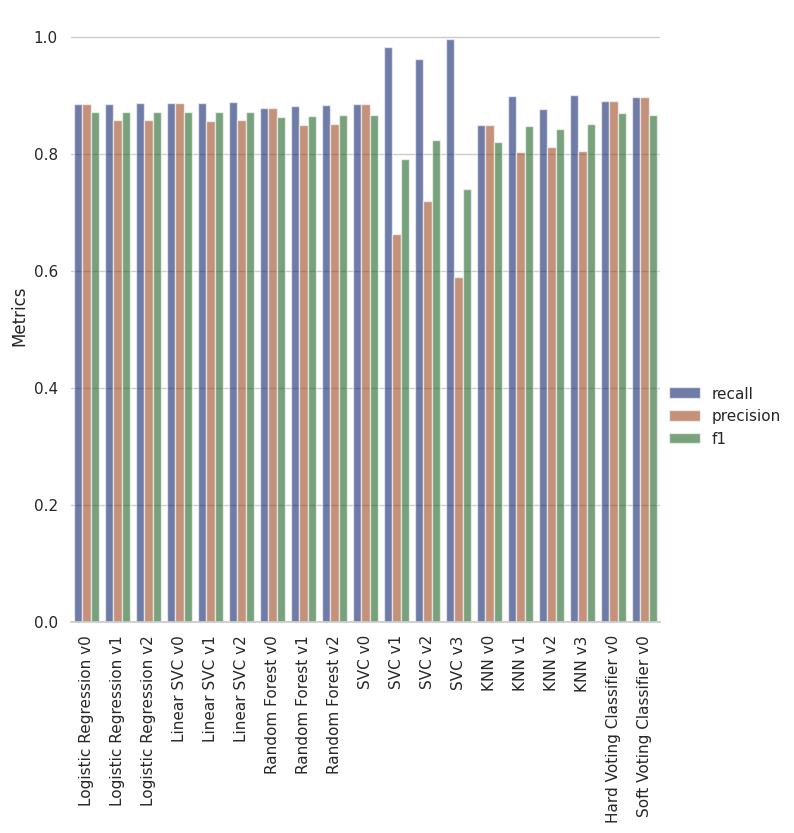

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=melted_training_metrics, kind="bar",
    x="model_name", y="score", hue="metric",
    palette="dark", alpha=.6, height=7
)    
    
plt.xticks(rotation=90)

g.despine(left=True)
g.set_axis_labels("", "Metrics")
g.legend.set_title("")


In [12]:
import plotly.express as px
 
fig = px.bar(melted_training_metrics, x="model_name", y="score",
             color="metric", hover_data=['score'],
             barmode = 'group')
 
fig.show()

Observations:
* Considering we want to balance `recall` and `precision` our previous assumption was that `Voting Classifier` did better than most of the previously trained models was wrong
* On looking at the visualization above it seems its just slightly better than default Logistic Regression. 

## Testing Helper Functions

In [13]:
import joblib


def create_estimator_mapping():
    estimators = []
    
    for entry in os.scandir(models_root_dir):  
        if entry.is_file():  # check if it's a file
            estimator_name = os.path.splitext(entry.name)[0]
            estimator = joblib.load(entry.path)
            estimators.append((estimator_name,estimator))
    
    return estimators

def run_tests(estimators, X_test,y_test):
    test_results = []
    for estimator_name, estimator in estimators:
        print(f"Classifying Data using {estimator_name}")
        predictions = estimator.predict(X_test)
        test_results.append((estimator_name,predictions))
        
    return test_results

def get_scores(predictions, true_values):
    recall = recall_score(true_values, predictions)
    precision = precision_score(true_values, predictions)
    f1 = f1_score(true_values, predictions)
    return recall,precision,f1


## Run Tests

In [14]:
## load estimators
estimators = create_estimator_mapping()

## run tests
test_results = run_tests(estimators=estimators,X_test=X_test,y_test=y_test)



Classifying Data using random_forest_v2
Classifying Data using random_forest_v1
Classifying Data using svc_v1
Classifying Data using linear_svc_v2
Classifying Data using knn_v2
Classifying Data using knn_v1
Classifying Data using linear_svc_v1
Classifying Data using knn_v3
Classifying Data using svc_v2
Classifying Data using soft_voting_classifier_v0
Classifying Data using logistic_regression_v1
Classifying Data using logistic_regression_v2
Classifying Data using svc_v3
Classifying Data using hard_voting_classifier_v0


In [15]:
## get scores
for estimator, predictions in test_results:
    recall,precision,f1 = get_scores(predictions=predictions,true_values=y_test)
    print(f"recall,precision,f1 for {estimator} are {recall,precision,f1}")
    common.update_test_data_metrics(estimator,recall,precision,f1)

recall,precision,f1 for random_forest_v2 are (0.8791309669522643, 0.8440070505287897, 0.8612110311750599)
recall,precision,f1 for random_forest_v1 are (0.883108935128519, 0.844847775175644, 0.8635547576301615)
recall,precision,f1 for svc_v1 are (0.9703182374541004, 0.6998455087177223, 0.8131811770739839)
recall,precision,f1 for linear_svc_v2 are (0.8828029375764994, 0.8548148148148148, 0.8685834713231974)
recall,precision,f1 for knn_v2 are (0.8714810281517748, 0.8120901055032792, 0.8407380073800738)
recall,precision,f1 for knn_v1 are (0.8876988984088128, 0.8018242122719734, 0.8425791460935231)
recall,precision,f1 for linear_svc_v1 are (0.883108935128519, 0.8543516873889876, 0.8684923262112549)
recall,precision,f1 for knn_v3 are (0.8910648714810282, 0.8033103448275862, 0.8449151312926158)
recall,precision,f1 for svc_v2 are (0.9476744186046512, 0.7484291928467859, 0.8363489062921955)
recall,precision,f1 for soft_voting_classifier_v0 are (0.8922888616891065, 0.8331428571428572, 0.86170212

## Visualize Results

In [16]:
test_data_metrics = pd.read_csv(Path(data_root_dir,"test_data_metrics.csv"))
test_data_metrics

,model,recall,precision,f1
0,random_forest_v2,0.879131,0.844007,0.861211
1,random_forest_v1,0.883109,0.844848,0.863555
2,svc_v1,0.970318,0.699846,0.813181
3,linear_svc_v2,0.882803,0.854815,0.868583
4,knn_v2,0.871481,0.812090,0.840738
5,knn_v1,0.887699,0.801824,0.842579
6,linear_svc_v1,0.883109,0.854352,0.868492
7,knn_v3,0.891065,0.803310,0.844915
8,svc_v2,0.947674,0.748429,0.836349
9,soft_voting_classifier_v0,0.892289,0.833143,0.861702


In [17]:
test_data_metrics["id"] = test_data_metrics.index
test_data_metrics.head()

,model,recall,precision,f1,id
0,random_forest_v2,0.879131,0.844007,0.861211,0
1,random_forest_v1,0.883109,0.844848,0.863555,1
2,svc_v1,0.970318,0.699846,0.813181,2
3,linear_svc_v2,0.882803,0.854815,0.868583,3
4,knn_v2,0.871481,0.812090,0.840738,4


In [18]:
melted_test_data_metrics = pd.melt(test_data_metrics,id_vars=["id","model"],value_vars=["recall","precision","f1"], var_name="metric", value_name="score")
melted_test_data_metrics

,id,model,metric,score
0,0,random_forest_v2,recall,0.879131
1,1,random_forest_v1,recall,0.883109
2,2,svc_v1,recall,0.970318
3,3,linear_svc_v2,recall,0.882803
4,4,knn_v2,recall,0.871481
5,5,knn_v1,recall,0.887699
6,6,linear_svc_v1,recall,0.883109
7,7,knn_v3,recall,0.891065
8,8,svc_v2,recall,0.947674
9,9,soft_voting_classifier_v0,recall,0.892289


In [20]:
import plotly.express as px
 
fig = px.bar(melted_test_data_metrics, x="model", y="score",
             color="metric", hover_data=['score'],
             barmode = 'group')
 
fig.show()

In [22]:
test_data_metrics.sort_values(by=["recall","precision"],ascending=False)

,model,recall,precision,f1,id
12,svc_v3,0.996328,0.587726,0.739328,12
2,svc_v1,0.970318,0.699846,0.813181,2
8,svc_v2,0.947674,0.748429,0.836349,8
9,soft_voting_classifier_v0,0.892289,0.833143,0.861702,9
7,knn_v3,0.891065,0.803310,0.844915,7
5,knn_v1,0.887699,0.801824,0.842579,5
6,linear_svc_v1,0.883109,0.854352,0.868492,6
13,hard_voting_classifier_v0,0.883109,0.848574,0.865497,13
1,random_forest_v1,0.883109,0.844848,0.863555,1
3,linear_svc_v2,0.882803,0.854815,0.868583,3


In [28]:
recall_threshold = 0.85
precision_threshold = 0.85
test_data_metrics.loc[(test_data_metrics["recall"] > recall_threshold) & (test_data_metrics["precision"] > precision_threshold)].sort_values(by=["recall","precision"],ascending=False)

,model,recall,precision,f1,id
6,linear_svc_v1,0.883109,0.854352,0.868492,6
3,linear_svc_v2,0.882803,0.854815,0.868583,3
10,logistic_regression_v1,0.882803,0.854815,0.868583,10
11,logistic_regression_v2,0.880355,0.856505,0.868266,11


Observations:
* The above visualization and table gives us a clear idea on which model to choose based on hypothetical threshold of `0.85`.